# Pre-URP D06 Templete Code
Made by Dongkyu Won & Soopil Kim & (Prof.) Sang Hyun Park - DGIST / Medical Image & Signal Processing Lab

# Install PyTorch
학습을 위한 패키지 설치를 합니다.
본 코드에서는 PyTorch를 사용합니다.

In [1]:
!pip3 install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install pydicom matplotlib simpleitk

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 24kB/s 
     |████████████████████████████████| 12.8MB 55kB/s 
     |████████████████████████████████| 7.6MB 7.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 1.9MB 18.3MB/s 
     |████████████████████████████████| 47.4MB 60kB/s 


# Mounting on Google Drive
- 먼저 본 연구에서 사용할 데이터세트와 코드 일부를 불러오기 위해 구글 드라이브를 연동시킵니다. 

- 출력되는 링크를 클릭하고 다음 구글 계정을 사용하여 연동합니다.
  - ID: mispl.edu 
  - PW: mispl6253

In [2]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive/')
  %cd /content/drive/My Drive/preurp2020_D06

Mounted at /content/drive
/content/drive/My Drive/preurp2020_D06


# Load CT Dataset

- 본 연구에서는 2016 AAPM Low-Dose CT Grand Challenge에서 제공되는 데이터세트를 사용합니다. (https://www.aapm.org/grandchallenge/lowdosect/)

- 미리 연결해둔 Google Drive에서 영상들의 경로를 불러옵니다.

- 총 10 Subject의 3D CT 영상데이터가 주어져있으며 각각 저방사선(Quarter-Dose)과 고방사선(Full-Dose) CT 영상 쌍으로 이루어져있습니다.

- 영상의 shape은 [Height, Width]의 형식으로 이루어져있습니다. 

- CT 영상데이터를 확인하기 위해서는 `pydicom` 패키지로 영상을 부르고 `matplotlib` 패키지를 이용하여 시각화합니다.

- 하나의 영상을 예시로 시각화해보겠습니다.

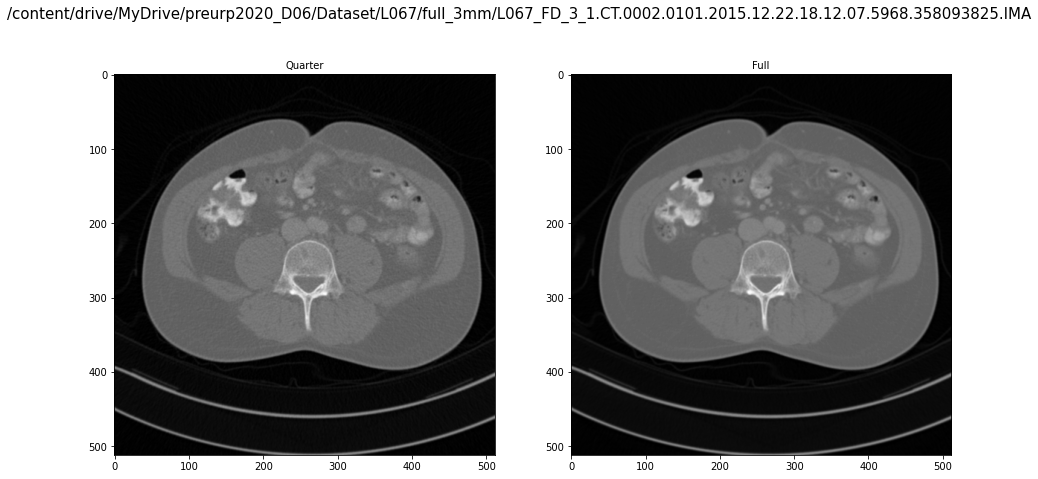

영상데이터 경로: /content/drive/MyDrive/preurp2020_D06/Dataset/L067/full_3mm/L067_FD_3_1.CT.0002.0101.2015.12.22.18.12.07.5968.358093825.IMA
영상데이터 사이즈 (세로, 가로): (512, 512)


In [3]:
import os
import glob
import numpy as np
import pydicom
import matplotlib.pyplot as plt


path = "/content/drive/MyDrive/preurp2020_D06/Dataset"
def load_dataset(path, fold=None, phase=None, valid=False):
    subjects_dict = {}
    image_pair_dict = {'full': [], 'quarter': []}
    subjects = os.listdir(path)

    if type(fold) == str:
        fold = int(fold)

    if valid:
        if phase == "train":
            del subjects[fold-1]
        elif phase == "valid":
            subjects = [subjects[fold-2]]
        elif phase == "test":
            subjects = [subjects[fold-1]]
        else:
            pass
    elif not valid:
        if phase == "train":
            del subjects[fold-1]
        elif phase == "valid" or phase == "test":
            subjects = [subjects[fold-1]]
        else:
            pass

    for subject in subjects:
        subjects_dict[subject] = os.path.join(path, subject)

    for key in subjects_dict.keys():
        inputs = sorted(glob.glob(os.path.join(subjects_dict[key], 'quarter_3mm', '*.IMA')))
        targets = sorted(glob.glob(os.path.join(subjects_dict[key], 'full_3mm', '*.IMA')))
        assert len(inputs) == len(targets)

        for i in range(len(inputs)):
            image_pair_dict['quarter'].append(inputs[i])
            image_pair_dict['full'].append(targets[i])

    return image_pair_dict

# 각각 학습, 검증, 테스트데이터를 나누어 불러옵니다.
trainset = load_dataset(path=path, fold=3, phase='train')
validset = load_dataset(path=path, fold=3, phase='valid')
testset = load_dataset(path=path, fold=3, phase='test')

# 예시로 학습데이터 중 하나의 슬라이스 영상을 불러오겠습니다.
sample_image_quarter = pydicom.dcmread(trainset["quarter"][100]).pixel_array
sample_image_full = pydicom.dcmread(trainset["full"][100]).pixel_array

# matplotlib을 사용하여 시각화합니다.
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle(trainset["full"][100], fontsize=15)
ax[0].imshow(sample_image_quarter, cmap='gray')
ax[0].set_title("Quarter", fontsize=10)
ax[0].grid(False)

ax[1].imshow(sample_image_full, cmap='gray')
ax[1].set_title("Full", fontsize=10)
ax[1].grid(False)
#fig.tight_layout()
plt.show()

print("영상데이터 경로:", trainset["full"][100])
print("영상데이터 사이즈 (세로, 가로):", sample_image_quarter.shape)

# Define Dataloader
- 데이터세트를 가져오기 위해서 `torch.utils.data.Dataset`를 이용한 클래스를 선언합니다.

- `Dataset` 클래스에는 `__len__`와 `__getitem__` 메소드가 있습니다. 
  - `__len__`: 데이터세트의 수 반환
  - `__getitem__`: 데이터를 반복하여 반환

- 작성된 코드에서는 CT 영상의 패치를 반환합니다.

torch.Size([4, 1, 64, 64])


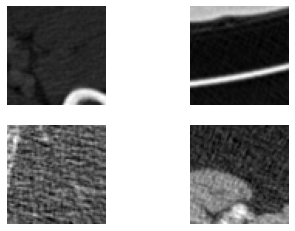

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from tools.img_aug_torch import toPIL, random_patches


class AAPM(Dataset):
    def __init__(self, dataset, mode, patch_size=64, num_patches=64):
        self.mode = mode
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.quarter = dataset['quarter']
        self.full = dataset['full']

    def __len__(self):
        return len(self.quarter)

    def __getitem__(self, idx):
        quarter = pydicom.dcmread(self.quarter[idx])
        full = pydicom.dcmread(self.full[idx])

        subject = self.quarter[idx].split('/')[-1].split('_')[0]
        slice = self.quarter[idx].split('/')[-1].split('.')[3]
        name = subject + '_' + slice

        input_img, label_img = quarter.pixel_array.astype(np.float32), full.pixel_array.astype(np.float32)
        input_img, label_img = np.expand_dims(input_img, axis=2), np.expand_dims(label_img, axis=2)

        if self.mode == "train":
            input_aug, label_aug = toPIL(input_img), toPIL(label_img)
            input_img, label_img = random_patches(input_aug, label_aug, self.patch_size, self.num_patches)
        elif self.mode == "valid" or self.mode == "test":
            input_img, label_img = input_img.transpose((2, 0, 1)), label_img.transpose((2, 0, 1))

        input_img = torch.from_numpy(input_img)
        label_img = torch.from_numpy(label_img)

        input_img = input_img / 4095.
        label_img = label_img / 4095.

        return dict(source=input_img, target=label_img, name=name)

# Dataloader의 선언은 다음과 같이 이루어집니다.
dataset_train = AAPM(mode='train', dataset=trainset, patch_size=64, num_patches=4)
dataset_valid = AAPM(mode='valid', dataset=validset, patch_size=64)

dataloader_train = DataLoader(dataset=dataset_train, batch_size=1, shuffle=True, num_workers=4, drop_last=True)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=1, shuffle=False, num_workers=4)

# 예시로 Dataloader가 어떤 영상을 반환하는지 시각화합니다.
for iter, batches in enumerate(dataloader_train):
    x, y = batches['source'].to('cuda:0'), batches['target'].to('cuda:0')
    x, y = x.squeeze(0), y.squeeze(0)
    print(x.shape)
    plt.figure()
    for i in range(x.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow(x[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()
    break

# Define Model - REDCNN
모델은 CT Denoising에서 가장 기본적으로 사용되는 REDCNN을 이용합니다.


In [5]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, out_ch=64, kernel_size=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.conv4 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.conv5 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)

        self.tconv1 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.tconv2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.tconv3 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.tconv4 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=0)
        self.tconv5 = nn.ConvTranspose2d(out_ch, 1, kernel_size=kernel_size, stride=1, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        residual_1 = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        residual_2 = out
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        residual_3 = out
        out = self.relu(self.conv5(out))
        # decoder
        out = self.tconv1(out)
        out += residual_3
        out = self.tconv2(self.relu(out))
        out = self.tconv3(self.relu(out))
        out += residual_2
        out = self.tconv4(self.relu(out))
        out = self.tconv5(self.relu(out))
        out += residual_1
        out = self.relu(out)
        return out


# Define Hyperparameter
- 학습 하이퍼 파라미터를 선언합니다.
  - `base_dir`: 이 폴더 위치를 기준으로 결과가 저장됩니다.
  - `data_dir`: 데이터세트가 위치한 폴더입니다. 
  - `model_name`: 모델의 이름입니다.
  - `num_epochs`: 총 학습할 Epoch 수입니다.
  - `val_epoch`: 몇 Epoch마다 검증을 할지를 결정합니다.
  - `learning_rate`: Learning rate입니다.
  - `batch_size`: Batch size 수 입니다. 본 코드에서는 1로 고정합니다.
  - `num_patches`: 영상 한 장에서 추출할 패치의 수입니다.
  - `patch_size`: 추출할 패치의 크기를 결정합니다.
  - `test_fold`: Cross-Validation 시에 
  - `scheduler`: Learning rate scheduling을 할지를 결정합니다.

- 본 코드에서는 Mini-Batch 사이즈가 batch_size * num_patches로 결정됩니다. 
  - batch_size는 1이고 num_patches가 16이라면 한 장의 CT 영상에서 패치 16개를 뽑아 학습루프에 입력합니다.

In [6]:
import easydict

params = easydict.EasyDict({
    "base_dir": "/content/drive/MyDrive/preurp2020_D06/runs" , 
    "data_dir": "/content/drive/MyDrive/preurp2020_D06/Dataset" , 
    "model_name": "redcnn" , 
    "num_epochs": 10 , 
    "val_epoch": 1 , 
    "learning_rate": 1e-4 , 
    "batch_size": 1 ,  
    "num_patches": 4 , 
    "patch_size": 64 , 
    "test_fold": '3' , 
    "scheduler": True , 
    "num_workers": 4 
    })

print(params)

{'base_dir': '/content/drive/MyDrive/preurp2020_D06/runs', 'data_dir': '/content/drive/MyDrive/preurp2020_D06/Dataset', 'model_name': 'redcnn', 'num_epochs': 10, 'val_epoch': 1, 'learning_rate': 0.0001, 'batch_size': 1, 'num_patches': 4, 'patch_size': 64, 'test_fold': '3', 'scheduler': True, 'num_workers': 4}


# Define Trainer
- 학습, 검증, 테스트 루프를 담고있는 클래스를 선언합니다.
  - `__init__`(): 클래스 선언자
  - `train()`: 학습을 진행하는 메소드 
  - `valid()`: 학습이 진행되고 있는지 검증하는 메소드
  - `test()`: 학습된 결과를 바탕으로 테스트하는 메소드

In [18]:
!pwd
import os
import time
from datetime import datetime

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

from utils.evaluation import compute_measure_torch
from utils.logging import init_csv, write_csv
from utils.save_img import plot_save_ct, trunc_denorm, save_nifti

class Trainer(object):
    def __init__(self, params, mode):
        # Model
        self.model_name = params.model_name
        self.model = Net()
        self.params = params

        if mode == 'train':
            # Training hyper-parameters
            self.step = 0
            self.num_epochs = params.num_epochs
            self.val_epoch = params.val_epoch
            self.batch_size = params.batch_size
            self.num_patches = params.num_patches
            self.learning_rate = params.learning_rate
            self.optimizer = optim.Adam(params=self.model.parameters(), lr=self.learning_rate)
            self.scheduler = params.scheduler
            if self.scheduler:
                self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', patience=5, factor=0.5, verbose=True)
            self.criterion = nn.MSELoss()

            # Create directories
            self.train_date = datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
            self.test_fold = params.test_fold
            self.exp_dir = os.path.join(params.base_dir, self.model_name, self.test_fold, self.train_date)
            self.checkpoints_path = os.path.join(self.exp_dir, 'checkpoints')
            self.results_path = os.path.join(self.exp_dir, 'results')
            self.create_directories()

            self.train_log = os.path.join(self.exp_dir, "train_log_" + self.train_date + '.csv')
            self.param_txt = os.path.join(self.exp_dir, "train_params_" + self.train_date + '.txt')
            self.print_params()
            init_csv(csv_file=self.train_log, init_header=['Epochs', 'PSNR', 'SSIM', 'RMSE'])

            # Evaluation Metric
            self.best_psnr = 0.0

            # Device settings
            # self.device = torch.device("cuda:" + params.device if torch.cuda.is_available() else "cpu")
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if 'cuda' in str(self.device):
                self.model.to(self.device)
                self.criterion.to(self.device)
        else:
            self.desc = params.desc
            self.test_date = params.test_date
            self.test_fold = params.test_fold
            self.test_epoch = params.test_epoch
            self.exp_dir = os.path.join(params.base_dir, self.model_name, self.test_fold, self.test_date)
            self.checkpoints_path = os.path.join(self.exp_dir, 'checkpoints')
            self.results_path = os.path.join(self.exp_dir, 'results')
            self.save_path = os.path.join(self.results_path, self.desc)

            os.makedirs(self.save_path, exist_ok=True)
            print('Create path: {}'.format(self.save_path))
            print()
            
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if self.test_epoch == 'best':
                self.model.load_state_dict(torch.load(os.path.join(self.checkpoints_path, "model_best.pth"), map_location=self.device))
            else:
                self.model.load_state_dict(torch.load(os.path.join(self.checkpoints_path, "model_epoch" + self.test_epoch + ".pth"), map_location=self.device))
            if 'cuda' in str(self.device):
                self.model.to(self.device)
            self.model.eval()

    def train(self, dataloader_train, dataloader_valid):
        start_time = time.time()
        for epoch in range(self.num_epochs):
            for idx, batches in enumerate(dataloader_train):
                inputs, labels = batches['source'].to(self.device), batches['target'].to(self.device)
                if self.num_patches > 1:
                    inputs, labels = inputs.squeeze(0), labels.squeeze(0)
                else:
                    inputs, labels = inputs.squeeze(1), labels.squeeze(1)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.step += 1
                if (idx + 1) % (len(dataloader_train) // 5) == 0:
                    print("Epoch: {}/{} | Step: {} | Loss: {:.9f} | Time: {:.1f}s".format(epoch + 1, self.num_epochs, self.step, loss, time.time() - start_time))

            model_path = os.path.join(self.checkpoints_path, "model_epoch{}.pth".format(epoch+1))
            torch.save(self.model.state_dict(), model_path)

            if (epoch + 1) % self.val_epoch == 0:
                self.model.eval()
                self.valid(dataloader_valid, epoch)
                self.model.train()

    def valid(self, dataloader_valid, epoch):
        print("Validation...")
        loss_valid = []
        ori_psnr, ori_ssim, org_rmse = [], [], []
        pred_psnr, pred_ssim, pred_rmse = [], [], []
        self.model.eval()
        with torch.no_grad():
            for idx, batches in tqdm(enumerate(dataloader_valid)):
                inputs, labels = batches['source'].to(self.device), batches['target'].to(self.device)
                outputs = self.model(inputs)

                loss_valid.append(self.criterion(outputs, labels).item())
                original_result, pred_result = compute_measure_torch(inputs, labels, outputs)
                ori_psnr.append(original_result[0])
                ori_ssim.append(original_result[1])
                org_rmse.append(original_result[2])
                pred_psnr.append(pred_result[0])
                pred_ssim.append(pred_result[1])
                pred_rmse.append(original_result[2])

                if len(dataloader_valid) // 2 == idx:
                    inputs_plot = inputs
                    outputs_plot = outputs.detach()
                    labels_plot = labels

        loss_avg = sum(loss_valid) / len(loss_valid)
        pred_psnr_avg = sum(pred_psnr) / len(pred_psnr)
        pred_ssim_avg = sum(pred_ssim) / len(pred_ssim)
        print("Epoch {} | Loss: {:.9f} | PSNR: {:.4f} | SSIM: {:.4f}\n".format(epoch + 1, loss_avg, pred_psnr_avg, pred_ssim_avg))

        if pred_psnr_avg > self.best_psnr:
            self.best_psnr = pred_psnr_avg
            model_path = os.path.join(self.checkpoints_path, "model_best.pth")
            torch.save(self.model.state_dict(), model_path)
            print("Save model to {}\n".format("model_best.pth"))
            write_csv(csv_file=self.train_log, log=[epoch+1, pred_psnr_avg, pred_ssim_avg, '^'], log_type="append")
        else:
            write_csv(csv_file=self.train_log, log=[epoch+1, pred_psnr_avg, pred_ssim_avg], log_type="append")

        if self.scheduler:
            self.scheduler.step(self.best_psnr)

        save_cfg = {'name': str(epoch), 'save_path': self.results_path,
                    'org_psnr': original_result[0], 'org_ssim': original_result[1],
                    'pred_psnr': pred_result[0], 'pred_ssim': pred_result[1]}
        plot_save_ct(inputs_plot, outputs_plot, labels_plot, save_cfg)

    def test(self, dataloader_test):
        pred_nifti = np.zeros(shape=(len(dataloader_test), 512, 512), dtype=np.int16)
        ori_psnr, ori_ssim, org_rmse = [], [], []
        pred_psnr, pred_ssim, pred_rmse = [], [], []
        self.model.eval()
        with torch.no_grad():
            for idx, batches in enumerate(dataloader_test):
                inputs, labels = batches['source'].to(self.device), batches['target'].to(self.device)
                name = batches['name'][0]
                # inputs, pad = self.pad(inputs)
                outputs = self.model(inputs)
                # inputs, outputs = self.remove_pad(inputs, pad), self.remove_pad(outputs, pad)

                original_result, pred_result = compute_measure_torch(inputs, labels, outputs)
                ori_psnr.append(original_result[0])
                ori_ssim.append(original_result[1])
                org_rmse.append(original_result[2])
                pred_psnr.append(pred_result[0])
                pred_ssim.append(pred_result[1])
                pred_rmse.append(original_result[2])

                save_cfg = {'name': '{}_{}'.format(str(self.desc), str(name)), 'save_path': self.save_path,
                            'org_psnr': original_result[0], 'org_ssim': original_result[1],
                            'pred_psnr': pred_result[0], 'pred_ssim': pred_result[1]}

                pred_nifti[len(dataloader_test) - idx - 1] = trunc_denorm(outputs.squeeze().cpu())
                # save_single_slice(outputs, save_cfg)
                plot_save_ct(inputs, outputs, labels, save_cfg)
                print("{} | PSNR: {:.4f} | SSIM: {:.4f}".format(idx + 1, pred_result[0], pred_result[1]))

        save_nifti(pred_nifti, save_cfg, self.params)
        pred_psnr_avg = sum(pred_psnr) / len(pred_psnr)
        pred_ssim_avg = sum(pred_ssim) / len(pred_ssim)

        print("Avg PSNR: {:.4f} | Avg SSIM: {:.4f}\n".format(pred_psnr_avg, pred_ssim_avg))

    # 디렉토리를 생성합니다.
    def create_directories(self):
        os.makedirs(self.exp_dir, exist_ok=True)
        print('Create path: {}'.format(self.exp_dir))

        os.makedirs(self.checkpoints_path, exist_ok=True)
        print('Create path: {}'.format(self.checkpoints_path))

        os.makedirs(self.results_path, exist_ok=True)
        print('Create path: {}'.format(self.results_path))
        print()

    # 학습에 어떤 하이퍼파라미터 세팅으로 설정되어있는지를 보여주고 텍스트 파일로 저장합니다.
    def print_params(self):
        """Formats parameters to print when training."""
        param_dict = vars(self.params)
        pretty = lambda x: x.replace('_', ' ').capitalize()
        print('Training parameters: ')
        print('\n'.join('  {} = {}'.format(pretty(k), str(v)) for k, v in param_dict.items()))
        print()

        param_list = []
        param_list.append('Training parameters: \n')
        param_list.append('\n'.join('  {} = {}'.format(pretty(k), str(v)) for k, v in param_dict.items()))
        with open(self.param_txt, 'at') as w:
            for param in param_list:
                w.write(param)   


/content/drive/MyDrive/preurp2020_D06


# Start training
데이터로더를 부르고 학습을 진행합니다.

In [8]:
dataset_train = AAPM(mode='train', dataset=trainset, patch_size=params.patch_size, num_patches=4)
dataset_valid = AAPM(mode='valid', dataset=validset, patch_size=params.patch_size)

dataloader_train = DataLoader(dataset=dataset_train, batch_size=params.batch_size, shuffle=True, num_workers=4, drop_last=True)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=params.batch_size, shuffle=False, num_workers=4)

train = Trainer(params=params, mode='train')
train.train(dataloader_train, dataloader_valid)

Create path: /content/drive/MyDrive/preurp2020_D06/runs/redcnn/3/2021-01-20-04:26:14
Create path: /content/drive/MyDrive/preurp2020_D06/runs/redcnn/3/2021-01-20-04:26:14/checkpoints
Create path: /content/drive/MyDrive/preurp2020_D06/runs/redcnn/3/2021-01-20-04:26:14/results

Training parameters: 
  Base dir = /content/drive/MyDrive/preurp2020_D06/runs
  Data dir = /content/drive/MyDrive/preurp2020_D06/Dataset
  Model name = redcnn
  Num epochs = 10
  Val epoch = 1
  Learning rate = 0.0001
  Batch size = 1
  Num patches = 4
  Patch size = 64
  Test fold = 3
  Scheduler = True
  Num workers = 4

Epoch: 1/10 | Step: 110 | Loss: 0.000699240 | Time: 13.8s
Epoch: 1/10 | Step: 220 | Loss: 0.000317357 | Time: 26.5s
Epoch: 1/10 | Step: 330 | Loss: 0.000257424 | Time: 38.2s
Epoch: 1/10 | Step: 440 | Loss: 0.000170580 | Time: 49.4s
Epoch: 1/10 | Step: 550 | Loss: 0.000150800 | Time: 61.2s
Validation...


128it [00:14,  8.76it/s]


Epoch 1 | Loss: 0.000033283 | PSNR: 44.8567 | SSIM: 0.9715

Save model to model_best.pth

Epoch: 2/10 | Step: 664 | Loss: 0.000092350 | Time: 78.8s
Epoch: 2/10 | Step: 774 | Loss: 0.000116695 | Time: 80.4s
Epoch: 2/10 | Step: 884 | Loss: 0.000088207 | Time: 81.9s
Epoch: 2/10 | Step: 994 | Loss: 0.000034477 | Time: 83.4s
Epoch: 2/10 | Step: 1104 | Loss: 0.000048127 | Time: 84.9s
Validation...


128it [00:06, 19.94it/s]


Epoch 2 | Loss: 0.000028663 | PSNR: 45.4952 | SSIM: 0.9730

Save model to model_best.pth

Epoch: 3/10 | Step: 1218 | Loss: 0.000023261 | Time: 93.8s
Epoch: 3/10 | Step: 1328 | Loss: 0.000053737 | Time: 95.4s
Epoch: 3/10 | Step: 1438 | Loss: 0.000022886 | Time: 96.9s
Epoch: 3/10 | Step: 1548 | Loss: 0.000062096 | Time: 98.6s
Epoch: 3/10 | Step: 1658 | Loss: 0.000026069 | Time: 100.1s
Validation...


128it [00:06, 19.96it/s]


Epoch 3 | Loss: 0.000046620 | PSNR: 43.3672 | SSIM: 0.9785

Epoch: 4/10 | Step: 1772 | Loss: 0.000070930 | Time: 109.3s
Epoch: 4/10 | Step: 1882 | Loss: 0.000033382 | Time: 110.9s
Epoch: 4/10 | Step: 1992 | Loss: 0.000033128 | Time: 112.5s
Epoch: 4/10 | Step: 2102 | Loss: 0.000042879 | Time: 114.0s
Epoch: 4/10 | Step: 2212 | Loss: 0.000034770 | Time: 115.5s
Validation...


128it [00:06, 19.96it/s]


Epoch 4 | Loss: 0.000028829 | PSNR: 45.4624 | SSIM: 0.9786

Epoch: 5/10 | Step: 2326 | Loss: 0.000015935 | Time: 124.5s
Epoch: 5/10 | Step: 2436 | Loss: 0.000035820 | Time: 126.0s
Epoch: 5/10 | Step: 2546 | Loss: 0.000014112 | Time: 127.5s
Epoch: 5/10 | Step: 2656 | Loss: 0.000015030 | Time: 129.2s
Epoch: 5/10 | Step: 2766 | Loss: 0.000024887 | Time: 130.9s
Validation...


128it [00:06, 19.74it/s]


Epoch 5 | Loss: 0.000021004 | PSNR: 46.8579 | SSIM: 0.9840

Save model to model_best.pth

Epoch: 6/10 | Step: 2880 | Loss: 0.000024042 | Time: 139.9s
Epoch: 6/10 | Step: 2990 | Loss: 0.000063199 | Time: 141.5s
Epoch: 6/10 | Step: 3100 | Loss: 0.000039281 | Time: 143.2s
Epoch: 6/10 | Step: 3210 | Loss: 0.000030738 | Time: 144.7s
Epoch: 6/10 | Step: 3320 | Loss: 0.000033059 | Time: 146.3s
Validation...


128it [00:06, 19.67it/s]


Epoch 6 | Loss: 0.000020613 | PSNR: 46.9443 | SSIM: 0.9847

Save model to model_best.pth

Epoch: 7/10 | Step: 3434 | Loss: 0.000013332 | Time: 155.4s
Epoch: 7/10 | Step: 3544 | Loss: 0.000052757 | Time: 157.0s
Epoch: 7/10 | Step: 3654 | Loss: 0.000049256 | Time: 158.6s
Epoch: 7/10 | Step: 3764 | Loss: 0.000023019 | Time: 160.2s
Epoch: 7/10 | Step: 3874 | Loss: 0.000041875 | Time: 161.6s
Validation...


128it [00:06, 19.69it/s]


Epoch 7 | Loss: 0.000041540 | PSNR: 43.8246 | SSIM: 0.9165

Epoch: 8/10 | Step: 3988 | Loss: 0.000019489 | Time: 170.6s
Epoch: 8/10 | Step: 4098 | Loss: 0.000027547 | Time: 172.2s
Epoch: 8/10 | Step: 4208 | Loss: 0.000020022 | Time: 173.7s
Epoch: 8/10 | Step: 4318 | Loss: 0.000026664 | Time: 175.4s
Epoch: 8/10 | Step: 4428 | Loss: 0.000032719 | Time: 177.0s
Validation...


128it [00:06, 19.52it/s]


Epoch 8 | Loss: 0.000017853 | PSNR: 47.5769 | SSIM: 0.9858

Save model to model_best.pth

Epoch: 9/10 | Step: 4542 | Loss: 0.000017800 | Time: 186.2s
Epoch: 9/10 | Step: 4652 | Loss: 0.000019721 | Time: 187.8s
Epoch: 9/10 | Step: 4762 | Loss: 0.000029171 | Time: 189.3s
Epoch: 9/10 | Step: 4872 | Loss: 0.000013300 | Time: 190.9s
Epoch: 9/10 | Step: 4982 | Loss: 0.000022594 | Time: 192.3s
Validation...


128it [00:06, 19.45it/s]


Epoch 9 | Loss: 0.000018850 | PSNR: 47.3435 | SSIM: 0.9848

Epoch: 10/10 | Step: 5096 | Loss: 0.000018294 | Time: 202.0s
Epoch: 10/10 | Step: 5206 | Loss: 0.000026030 | Time: 203.7s
Epoch: 10/10 | Step: 5316 | Loss: 0.000016509 | Time: 205.2s
Epoch: 10/10 | Step: 5426 | Loss: 0.000017253 | Time: 206.8s
Epoch: 10/10 | Step: 5536 | Loss: 0.000023243 | Time: 208.3s
Validation...


128it [00:06, 18.42it/s]


Epoch 10 | Loss: 0.000021961 | PSNR: 46.6479 | SSIM: 0.9822



# Define test parameter
- 테스트 파라미터를 선언합니다.
  - `base_dir`: 이 폴더 위치를 기준으로 결과가 저장됩니다.
  - `data_dir`: 데이터세트가 위치한 폴더입니다. 
  - `model_name`: 모델의 이름입니다.
  - `subject`: 테스트하는 subject의 이름입니다.
  - `desc`: 총 학습할 Epoch 수입니다.
  - `test_epoch`: 몇 번째 epoch의 모델을 가지고 테스트할지를 결정합니다.
  - `test_date`: 학습이 시작됐던 때의 시간입니다.
  - `test_fold`: Cross-Validation test시에 몇번째 fold를 테스트할 것인지 결정합니다. 


In [38]:
params_test = easydict.EasyDict({
    "base_dir": "/content/drive/MyDrive/preurp2020_D06/runs" , 
    "data_dir": "/content/drive/MyDrive/preurp2020_D06/Dataset" , 
    "model_name": "redcnn" ,
    "subject": "L109",  
    "desc": "test", 
    "test_epoch": "10" , 
    "test_date": '2021-01-20-04:26:14' ,
    "test_fold": '3' , 
    "patch_size": 64 ,  
    "num_workers": 4 
    })

print(params_test)

L109


# Start test
데이터로더를 부르고 테스트를 진행합니다.

In [41]:
dataset_test = AAPM(mode='valid', dataset=testset, patch_size=params_test.patch_size)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False, num_workers=params_test.num_workers)

test = Trainer(params=params_test, mode='test')
test.test(dataloader_test)

Create path: /content/drive/MyDrive/preurp2020_D06/runs/redcnn/3/2021-01-20-04:26:14/results/test

1 | PSNR: 46.9641 | SSIM: 0.9848
2 | PSNR: 47.3503 | SSIM: 0.9862
3 | PSNR: 47.5812 | SSIM: 0.9870
4 | PSNR: 47.5611 | SSIM: 0.9870
5 | PSNR: 47.8691 | SSIM: 0.9878
6 | PSNR: 48.0672 | SSIM: 0.9884
7 | PSNR: 48.0175 | SSIM: 0.9884
8 | PSNR: 48.3636 | SSIM: 0.9893
9 | PSNR: 48.5391 | SSIM: 0.9900
10 | PSNR: 48.4262 | SSIM: 0.9898
11 | PSNR: 48.6844 | SSIM: 0.9903
12 | PSNR: 48.7352 | SSIM: 0.9901
13 | PSNR: 48.5368 | SSIM: 0.9895
14 | PSNR: 48.6417 | SSIM: 0.9899
15 | PSNR: 48.6077 | SSIM: 0.9899
16 | PSNR: 48.3607 | SSIM: 0.9894
17 | PSNR: 48.3553 | SSIM: 0.9891
18 | PSNR: 48.2009 | SSIM: 0.9885
19 | PSNR: 47.7688 | SSIM: 0.9872
20 | PSNR: 47.6643 | SSIM: 0.9866
21 | PSNR: 47.4761 | SSIM: 0.9857
22 | PSNR: 46.9380 | SSIM: 0.9836
23 | PSNR: 46.9704 | SSIM: 0.9835
24 | PSNR: 46.9109 | SSIM: 0.9833
25 | PSNR: 46.5134 | SSIM: 0.9818
26 | PSNR: 46.5951 | SSIM: 0.9823
27 | PSNR: 46.5398 | SSIM: